# Load a random image

Batch of images has shape:  torch.Size([1, 512, 512])
Batch of labels:  tensor([51])
Dataset length = 83


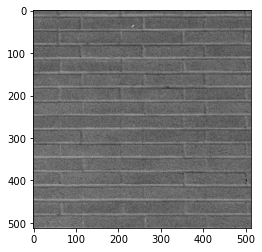

In [91]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from dataloader import CustomDataset

# path to dataset images
path = 'datasets/USC_SIPI/'
# create dataset
usc_sipi_set = CustomDataset(path)
# create dataloader
usc_sipi_loader = DataLoader(usc_sipi_set, batch_size=1, shuffle=True)
# test dataloader
for imgs, labels in usc_sipi_loader:
    print("Batch of images has shape: ",imgs.shape)
    print("Batch of labels: ", labels)
    plt.imshow(imgs[0,:,:],cmap='gray')
    break
print('Dataset length =',len(usc_sipi_set))

# Study metrics

$\mathbf{RMSE} = \frac{1}{MN} \sum_{i=0}^{M} \sum_{j=0}^{N} \big| \mathbf{I}(i,j) - \hat{\mathbf{I}}(i,j)\big|^2$, where

$\mathbf{I}$ - original image;

$\hat{\mathbf{I}}$ - distorted image;

$M$ - image height;

$N$ - image width.

$\mathbf{PSNR} = 10 \log_{10}{ \big( \frac{\mathbf{MAX_I}}{\mathbf{RMSE}}\big)^2}$, where

$\mathbf{MAX_I}$ - maximal possible intensity in the image;

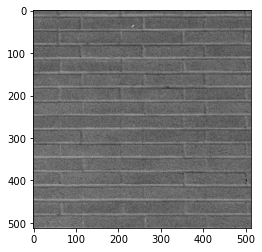

In [92]:
img_original = imgs[0]
plt.imshow(img_original,cmap='gray')

# Try low-rank approximation to destroy the image

$\mathbf{I} = \mathbf{U S V}^T, \mathbf{U} \in \mathbb{R}^{m \times k},\mathbf{S} \in \mathbb{R}^{k \times k},\mathbf{V} \in \mathbb{R}^{n \times k}$

For low-rank approximation: $r < k$.

$\hat{\mathbf{I}} = \mathbf{U}_r \mathbf{S}_r \mathbf{V}_r, \mathbf{U}_r \in \mathbb{R}^{m \times r},\mathbf{S}_r \in \mathbb{R}^{r \times r},\mathbf{V}_r \in \mathbb{R}^{n \times r}$

In [93]:
# SVD
U,S,V = torch.linalg.svd(torch.tensor(imgs[0].clone().detach(),dtype=torch.float))
# approximation
r = 10
img_rec = U[:,:r] @ np.diag(S[:r]) @ V[:r,:]

# consider value constraints
img_rec[img_rec > 255] = 255
img_rec[img_rec < 0] = 0

# change data type
img_rec = torch.tensor(img_rec,dtype=torch.uint8)

<ipython-input-93-d01e4ff8d10f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U,S,V = torch.linalg.svd(torch.tensor(imgs[0].clone().detach(),dtype=torch.float))
<ipython-input-93-d01e4ff8d10f>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_rec = torch.tensor(img_rec,dtype=torch.uint8)


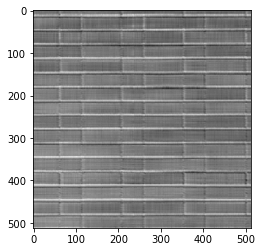

In [94]:
plt.imshow(img_rec,cmap='gray')

In [95]:
def get_RMSE(image_a,image_b):
    """
    Input: image_a, image_b - images with size a*b
    Output: root mean square error (RMSE)
    """
    # get shape
    a,b = image_a.shape
    # calculate RMSE by definition
    RMSE = torch.sqrt((1/(a*b))*torch.sum(torch.abs(image_a - image_b)**2))
    return RMSE

def get_PSNR(image_a,image_b):
    """
    Input: image_a, image_b - images with size a*b
    Output: peak signal-to-noise ratio (PSNR)
    """
    # get RMSE
    RMSE = get_RMSE(image_a,image_b)
    # maximum possible intensity for torch.uint8 dtype
    MAX_I = 255
    # calculate PSNR by definition
    PSNR = 10*torch.log10((MAX_I/RMSE)**2)
    return PSNR

In [96]:
RMSE = get_RMSE(img_original,img_rec)
RMSE

tensor(6.0150)

In [102]:
(torch.norm(img_original-img_rec,'fro')**2)/512**2

tensor(36.1802)

In [97]:
MSE = RMSE**2
MSE

tensor(36.1802)

In [98]:
PSNR = get_PSNR(img_original,img_rec)
PSNR

tensor(32.5461)